### Load Packages

In [2]:
import pandas as pd
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pickle
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import seaborn as sns
import gc
import itertools
import random
sys.path.append('../')

In [ ]:
!pip install shapely

### Simulation Functions
TODO: Move to separate .py file

In [3]:
"""
Vectorized Euclidian Distance Function
"""
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

"""
Generate seating plan given a room, number of students, proportion of students vaccinated
"""
def generate_seating_plan(N,p,room):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    
    grid = room.copy()
    grid = grid.reset_index()
    grid['seating'] = 'E'

    gridunvax = grid[grid['UnvaxSpot'] == 1]
    unvax_seats = list(gridunvax['index'].sample(Nunvax).values)
    grid['seating'].loc[grid['index'].isin(unvax_seats)] = 'U'
    
    vax_seats = random.sample(Diff(list(grid['index'].values),unvax_seats),Nvax)
    grid['seating'].loc[grid['index'].isin(vax_seats)] = 'V'
    
    return grid

""" generate random seating plan
room argument is irrelevant
"""
def generate_random_plan(N,p,room):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    
    room = room.drop('UnvaxSpot',axis = 1)
    grid = room.copy()
    grid = grid.reset_index()
    temp = list(np.append(np.append(np.repeat('V',Nvax),np.repeat('U',Nunvax)),np.repeat('E',len(grid)-Nvax-Nunvax)))
    random.shuffle(temp)
    grid['seating'] = temp
    return grid


"""
Arguments:
    Room: Room object generated from function above
    vax_infected: number of students in room vaccinated and infected
    unvax_infected: number of students if unvaccinated and infectied
    time: time of classroom
    function: function to return probability of infection for an uninfected student given 
                distance to other infected students and exposure time
    
    
Returns: Number of students infected

"""
def simulate_class(room,vax_infected, unvax_infected, time, function):
    
    room = room.reset_index()
    vax_infect_id = random.sample(list(room[room['seating'] == 'V']['index'].values), vax_infected)
    unvax_infect_id = random.sample(list(room[room['seating'] == 'U']['index'].values), unvax_infected)
    infected = room[room['index'].isin(np.append(vax_infect_id,unvax_infect_id))]
    uninfected = room[ (~room['index'].isin(np.append(vax_infect_id,unvax_infect_id))) & \
                      (room['seating'] != 'E')  ]

    p_infections = []
    for i,row in uninfected.iterrows():
        x = row['x']
        y = row['y']
        status = row['seating']

        distance_unvax_infected = ((infected[infected['seating'] == 'U']['x'] -
                     x) ** 2 + (infected[infected['seating'] == 'U']['y'] - y) ** 2) ** 0.5

        distance_vax_infected = ((infected[infected['seating'] == 'V']['x'] -
                     x) ** 2 + (infected[infected['seating'] == 'V']['y'] - y) ** 2) ** 0.5
        
        p = function(status, distance_unvax_infected,distance_vax_infected, time)
        p_infections.append(p)
     
    return np.sum(p_infections)


"""
Distance to probability function for: U - U , U - V, V - U, V-V
"""
def distance_to_prob(status,distance_unvax_infected, distance_vax_infected ,time):
    distance_unvax_infected = distance_unvax_infected/pixels_per_foot*0.3048
    distance_vax_infected = distance_vax_infected/pixels_per_foot*0.3048
    
    # flip around
    if status == 'V':

        c1 = 0.999977
        c2 = 0.000097
        
    elif status == 'U':
   
        c1 = 0.99907
        c2 = 0.00039
    
    
    tot_prob = 0
    
    for dist in distance_unvax_infected:
        prob = c1*dist**c2
        tot_prob = tot_prob + max((1-prob),0)
        
    for dist in distance_vax_infected:
        prob = c1*dist**c2
        tot_prob = tot_prob + 0.25*max((1-prob),0)
        
    return tot_prob

"""
Biased coin flipper
"""
def flip(p):
    return 1 if random.random() < p else 0

### Load Room Layouts

In [4]:
with open("../Data/phl219_1foot.pickle" , 'rb') as handle:
    results_1feet = pickle.load(handle)

with open("../Data/phl219_2foot.pickle" , 'rb') as handle:
    results_2feet = pickle.load(handle)

with open("../Data/phl219_3foot.pickle" , 'rb') as handle:
    results_3feet = pickle.load(handle)

with open("../Data/phl219_4foot.pickle" , 'rb') as handle:
    results_4feet = pickle.load(handle)

with open("../Data/phl219_5foot.pickle" , 'rb') as handle:
    results_5feet = pickle.load(handle)

with open("../Data/phl219_6foot.pickle" , 'rb') as handle:
    results_6feet = pickle.load(handle)
    
pixels_per_foot = (2954-1826)/20
total_seats = 94

layouts = [results_1feet,results_2feet,results_3feet,results_4feet,results_5feet,results_6feet]
feets = [1,2,3,4,5,6]

rooms = []
unvax_prop = []
i = 0
for layout in layouts:
    ft = feets[i]
    x_coord = [i.x for i in layout['Middles']]
    y_coord = [i.y for i in layout['Middles']]
    room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
    room['UnvaxSpot'] = layout['In Solution']
    room['feet_apart'] = ft
    unvax_prop.append(sum(room['UnvaxSpot'])/len(room))
    rooms.append(room)
    plt.figure()
    plt.scatter(room[room['UnvaxSpot'] == 0]['x'],room[room['UnvaxSpot'] == 0]['y'])
    plt.scatter(room[room['UnvaxSpot'] == 1]['x'],room[room['UnvaxSpot'] == 1]['y'])
    plt.title('PHL219: ' + str(ft) + ' Feet Social Distancing')
    i = i + 1 


plt.figure()
plt.scatter(feets,unvax_prop)
plt.plot(feets,unvax_prop)
plt.xlabel('Feet Social Distancing')
plt.ylabel('% Seats Allocated to Unvax')
plt.title('PHL219')

ModuleNotFoundError: No module named 'shapely'

### Experiment 1: Recreate Fall 2020 Seating Plan and Assess Risk

Text(0.5, 1.0, 'Fall 2020 Seating Plan')

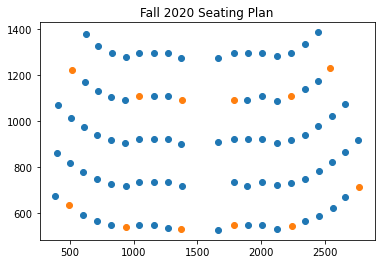

In [4]:
FA2020room = rooms[0].copy()
FA2020room['label'] = FA2020room.index

#Set label_seats = TRUE to hand label which seats were used in 2020
label_seats = False
if label_seats == True:
    fig, ax = plt.subplots(figsize=(12,10))
    ax.scatter(FA2020room['x'],FA2020room['y'])
    for i, txt in enumerate(FA2020room['label'].values):
        ax.annotate(txt, (FA2020room['x'][i],baseroom['y'][i]))
indicies = [55,50,10,63,76,93,29,35,33,24,72,88]

FA2020room['UnvaxSpot'] = 0
FA2020room['UnvaxSpot'].iloc[indicies] = 1
FA2020room.drop('label', axis =1,inplace = True)
FA2020room['seating'] = 'E'
FA2020room['seating'].loc[FA2020room['UnvaxSpot'] == 1] = 'U'
plt.figure()
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'])
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 1]['x'],FA2020room[FA2020room['UnvaxSpot'] == 1]['y'])
plt.title('Fall 2020 Seating Plan')

In [5]:
gc.collect()
i = 0
results2020 = []
while i < 100:
    infect = simulate_class(FA2020room,0, 1, 1, distance_to_prob)
    results2020.append(infect)
    i = i+1
Fall2020_risk = (np.mean(results2020)*1/1000)
print('Fall2020Risk: ' + str(Fall2020_risk))
print('Secondary Infections ' + str(np.mean(results2020)))

Fall2020Risk: 3.3977414069526755e-06
Secondary Infections 0.0033977414069526757


### Experiment 2: Fill Rooms to Maximum Capacity and Assess Risk

In [6]:
room_list =  rooms
max_seating = []

#Fill Rooms to Max Capacity
for room in room_list:
    room = room.copy()
    room['seating'] = 'V'
    room['seating'].loc[room['UnvaxSpot'] == 1] = 'U'
    max_seating.append(room)

secondary_infections = []

for seated_room in max_seating:
    gc.collect()
    i = 0
    results = []
    prop_vax = 1-sum(seated_room['UnvaxSpot'])/len(seated_room)
    p_generate = prop_vax /(4-3*prop_vax)
    
    while i < 100:
        ind = flip(p_generate)
        if sum(seated_room['UnvaxSpot']) == len(seated_room):
            ind = 0
        infect = simulate_class(seated_room,ind, 1-ind, 1, distance_to_prob)
        results.append(infect)
        i = i+1
    temp = (np.mean(results))
    secondary_infections.append(temp)
max_outside_prevelance = [Fall2020_risk/x for x in secondary_infections]

Text(0.5, 1.0, 'Fully Occupied Classrooms')

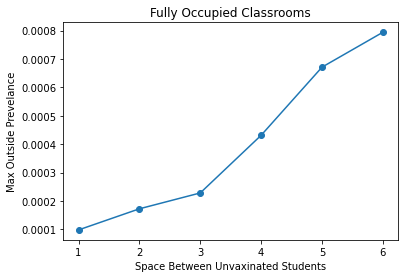

In [7]:
plt.plot(feets,max_outside_prevelance)
plt.scatter(feets,max_outside_prevelance)
plt.xlabel('Space Between Unvaxinated Students')
plt.ylabel('Max Outside Prevelance')
plt.title('Fully Occupied Classrooms')

### Experiment 3: Vary Classroom Density and Proportion of Students Vaccinated

In [8]:
N_range = np.arange(12,94,6)
p_range = np.arange(0,1.1,.1)
room_list =  rooms
results = []

for N in N_range:
    for p in p_range:
        print(N,p)
        for room in room_list:
            gc.collect()
            try:
                trial = 0
                while trial < 50:
                    grid = generate_seating_plan(N,p,room)
                    p_generate = p /(4-3*p)
                    ind = flip(p_generate)
                    
                    if sum(room['UnvaxSpot']) == len(room):
                        ind = 0    
                    elif sum(grid['seating'] == 'V') == 0:
                        ind = 0
                    elif sum(grid['seating'] == 'U') == 0:
                        ind = 1
                    infect = simulate_class(grid,ind, 1-ind,1,distance_to_prob)
                    number_unvax = sum(grid['seating']=='U')
                    results.append([N,p,infect,number_unvax,sum(room['UnvaxSpot']),ind, np.mean(room['feet_apart'])])
                    trial = trial+ 1
            except:
                print('error')
            
results = pd.DataFrame(results,columns = ['N','p','infected','number_unvax','number_unvax_seats','ind','feet_apart'])

12 0.0
12 0.1
12 0.2
12 0.30000000000000004
12 0.4
12 0.5
12 0.6000000000000001
12 0.7000000000000001
12 0.8
12 0.9
12 1.0
error
18 0.0
18 0.1
18 0.2
18 0.30000000000000004
18 0.4
18 0.5
18 0.6000000000000001
18 0.7000000000000001
18 0.8
18 0.9
18 1.0
error
24 0.0
error
error
24 0.1
error
24 0.2
24 0.30000000000000004
24 0.4
24 0.5
24 0.6000000000000001
24 0.7000000000000001
24 0.8
24 0.9
24 1.0
error
30 0.0
error
error
30 0.1
error
error
30 0.2
error
error
30 0.30000000000000004
error
30 0.4
30 0.5
30 0.6000000000000001
30 0.7000000000000001
30 0.8
30 0.9
30 1.0
error
36 0.0
error
error
error
36 0.1
error
error
error
36 0.2
error
error
36 0.30000000000000004
error
error
36 0.4
error
36 0.5
36 0.6000000000000001
36 0.7000000000000001
36 0.8
36 0.9
36 1.0
error
42 0.0
error
error
error
42 0.1
error
error
error
42 0.2
error
error
error
42 0.30000000000000004
error
error
42 0.4
error
error
42 0.5
error
42 0.6000000000000001
42 0.7000000000000001
42 0.8
42 0.9
42 1.0
error
48 0.0
error
err

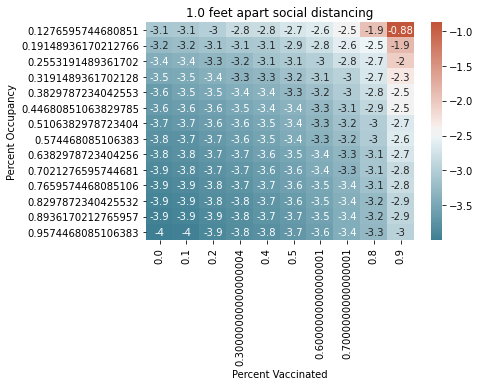

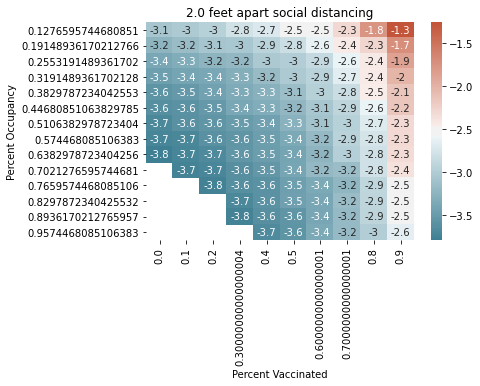

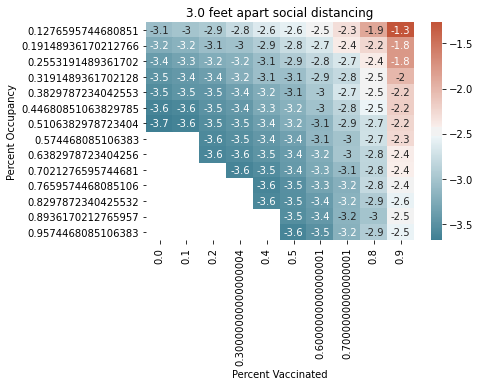

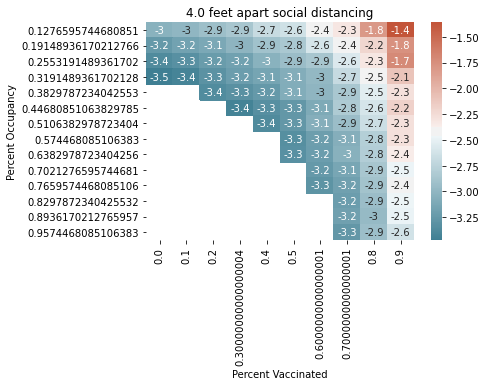

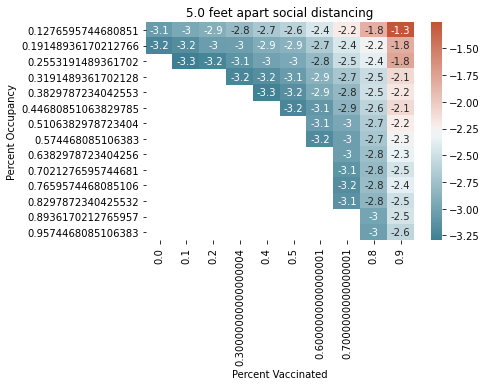

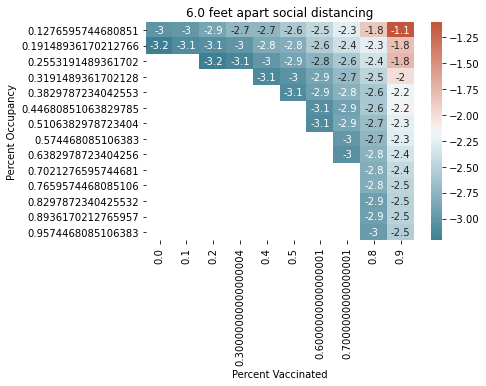

In [16]:
results['p_max']= [Fall2020_risk/x for x in results['infected'].values]
results['Percent Occupancy'] = results['N']/total_seats
results['Percent Vaccinated'] = results['p']
cmap = sns.diverging_palette(220, 20, as_cmap=True)
to_plot = results.copy()

for feet_apart in np.unique(to_plot['feet_apart'].values):
    plt.figure()
    p1 = to_plot[to_plot['feet_apart'] == feet_apart]
    p1 = p1[p1['Percent Vaccinated'] < 1]
    p1['lnpmax'] = np.log10(p1['p_max'])
    p1 = p1[p1['lnpmax'] < 0]
    agg_results = p1.groupby(['Percent Occupancy','Percent Vaccinated']).lnpmax.mean().reset_index()
    sns.heatmap(agg_results.pivot('Percent Occupancy','Percent Vaccinated','lnpmax'), cmap=cmap, annot = True)
    plt.title(str(feet_apart) + ' feet apart social distancing')

### Experiment 4: Planned Seating vs. Random Seating
3 feet social distancing, 50 percent vaccinated, full classroom

In [37]:
### Planned Seating
room = rooms[2]
N = total_seats
p = 0.5
experiment4_results = []
trial = 0
ntrials = 1000
while trial < ntrials:
    grid = generate_seating_plan(N,p,room)
    p_generate = p /(4-3*p)
    ind = flip(p_generate)
                    
    if sum(room['UnvaxSpot']) == len(room):
        ind = 0    
    elif sum(grid['seating'] == 'V') == 0:
        ind = 0
    elif sum(grid['seating'] == 'U') == 0:
        ind = 1
    
    infect = simulate_class(grid,ind, 1-ind,1,distance_to_prob)
    number_unvax = sum(grid['seating']=='U')
    experiment4_results.append([N,p,infect,number_unvax,sum(room['UnvaxSpot']),ind, np.mean(room['feet_apart'])])
    trial = trial + 1
    
experiment4_results = pd.DataFrame(experiment4_results,columns = ['N','p','infected','number_unvax','number_unvax_seats','ind','feet_apart'])

Planned Seating CI
-3.596159635453198 -3.5672972716735765


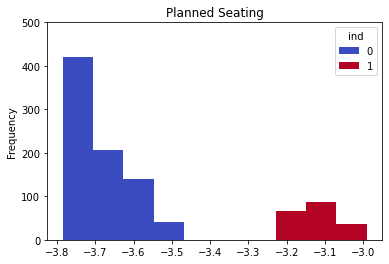

In [41]:
experiment4_results['pmax'] = [np.log10(Fall2020_risk/y) for y in experiment4_results['infected']]
experiment4_results.pivot(columns="ind", values="pmax").plot.hist(cmap='coolwarm') 
plt.title('Planned Seating')
plt.ylim(0,500)
mean = np.mean(experiment4_results['pmax'])
std = np.std(experiment4_results['pmax'])
LL = mean - 1.96*std/np.sqrt(ntrials)
UL = mean + 1.96*std/np.sqrt(ntrials)
print('Planned Seating CI')
print(LL,UL)

In [39]:
### Random Seating
experiment4_results_random = []
trial = 0
while trial < ntrials:
    grid = generate_random_plan(N,p,room)
    p_generate = p /(4-3*p)
    ind = flip(p_generate)
                    
    if sum(room['UnvaxSpot']) == len(room):
        ind = 0    
    elif sum(grid['seating'] == 'V') == 0:
        ind = 0
    elif sum(grid['seating'] == 'U') == 0:
        ind = 1
        
    infect = simulate_class(grid,ind, 1-ind,1,distance_to_prob)
    number_unvax = sum(grid['seating']=='U')
    experiment4_results_random.append([N,p,infect,number_unvax,sum(room['UnvaxSpot']),ind, np.mean(room['feet_apart'])])
    trial = trial + 1

experiment4_results_random = pd.DataFrame(experiment4_results_random,columns = ['N','p','infected','number_unvax','number_unvax_seats','ind','feet_apart'])

Ramdom Seating CI
-3.599730457888479 -3.568942121552156


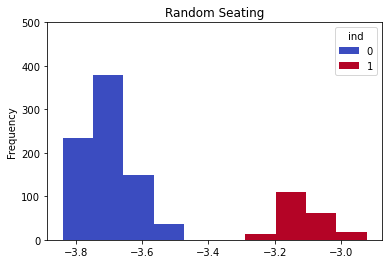

In [43]:
experiment4_results_random['pmax'] = [np.log10(Fall2020_risk/y) for y in experiment4_results_random['infected']]
experiment4_results_random.pivot(columns="ind", values="pmax").plot.hist(cmap='coolwarm') 
plt.title('Random Seating')
plt.ylim(0,500)
mean = np.mean(experiment4_results_random['pmax'])
std = np.std(experiment4_results_random['pmax'])
LL = mean - 1.96*std/np.sqrt(ntrials)
UL = mean + 1.96*std/np.sqrt(ntrials)
print('Ramdom Seating CI')
print(LL,UL)

### Experiment 5: Vary Classroom Density and Proportion of Students Vaccinated

In [ ]:
results_rand = []
for N in N_range:
    for p in p_range:
        print(N,p)
        room = rooms[0]
        trial = 0
        while trial < 50:
            grid = generate_random_plan(N,p,room)
            prop_vax = p
                    
            p_generate = prop_vax /(4-3*prop_vax)
            ind = flip(p_generate)
 
            if sum(grid['seating'] == 'V') == 0:
                ind = 0
            elif sum(grid['seating'] == 'U') == 0:
                ind = 1
                    
            infect = simulate_class(grid,ind, 1-ind,1,distance_to_prob)
            number_unvax = sum(grid['seating']=='U')
            results_rand.append([N,p,infect,number_unvax,sum(room['UnvaxSpot']),ind ])
            trial = trial + 1

12 0.0
12 0.1
12 0.2
12 0.30000000000000004
12 0.4
12 0.5
12 0.6000000000000001
12 0.7000000000000001
12 0.8
12 0.9
12 1.0
18 0.0
18 0.1
18 0.2
18 0.30000000000000004
18 0.4
18 0.5
18 0.6000000000000001
18 0.7000000000000001
18 0.8
18 0.9
18 1.0
24 0.0
24 0.1


In [50]:
sum(room['UnvaxSpot'])

94.0

In [45]:
ind

0

In [ ]:
results_rand =  pd.DataFrame(results_rand,columns = ['N','p','infected','number_unvax','number_unvax_seats','ind'])
results_rand['p_max']= [Fall2020_risk/x for x in results_rand['infected'].values]
results_rand['Percent Occupancy'] = results_rand['N']/290
results_rand['Percent Vaccinated'] = results_rand['p']
cmap = sns.diverging_palette(220, 20, as_cmap=True)
to_plot = results_rand.copy()